In [11]:
import pandas as pd
import os

# === USER CONFIGURATION ===
input_file = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Counts/output_csvs/Counts_BS28195A"  # path to your counts file (from pipeline)
output_file = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_TU_Distribution.xlsx"  # desired output path

# === PARAMETERS ===
promoters = ['Ef1a', 'PGK']
mts_promoters = [f'{p}-MTS' for p in promoters]
cds = ['GFP', 'ilvA', 'ilvA mut 1', 'ilvA mut 2', 'ilvG', 'ilvM', 'ilvB', 'ilvN', 'ilvC', 'ilvD']

# === LOAD DATA ===
df = pd.read_csv(input_file, skiprows=13, names=['BC Number', 'BC Name', 'Sequence', 'Counts'], encoding='utf-8-sig')

# Drop any bad lines and convert count column to int
df = df[pd.to_numeric(df['Counts'], errors='coerce').notna()].copy()
df['Counts'] = df['Counts'].astype(int)

# Normalize so total counts across the file sum to 100
total_reads = df['Counts'].sum()
normalization_value = 1 / total_reads

# Filter for usable barcodes (exclude "Unassigned" and include only relevant promoters)
df_filtered = df[
    (~df['BC Name'].str.contains("Unassigned")) &
    (df['BC Name'].str.contains("Ef1a__|PGK__|CMV__|TightTRE__|NoProm__|Ef1a-MTS__|PGK-MTS__|CMV-MTS__|TightTRE-MTS__|NoProm-MTS__|__Ef1a|__PGK|__CMV|__TightTRE|__NoProm"))
]

# === TU COUNTING ===
sum_TU = {}

# Count regular (non-MTS) promoter-CDS combinations
for promoter in promoters:
    for cd in cds:
        fwd = df_filtered['BC Name'].str.contains(f"{cd}__{promoter}(?!-MTS)", regex=True)
        rev = df_filtered['BC Name'].str.contains(f"{promoter}__{cd}(?!-MTS)", regex=True)
        sum_TU[f'{promoter}_{cd}'] = (df_filtered.loc[fwd, 'Counts'].sum() + df_filtered.loc[rev, 'Counts'].sum()) * normalization_value

# Count MTS promoter-CDS combinations
for promoter in mts_promoters:
    for cd in cds:
        fwd = df_filtered['BC Name'].str.contains(f"{cd}__{promoter}")
        rev = df_filtered['BC Name'].str.contains(f"{promoter}__{cd}")
        sum_TU[f'{promoter}_{cd}'] = (df_filtered.loc[fwd, 'Counts'].sum() + df_filtered.loc[rev, 'Counts'].sum()) * normalization_value

# === EXPORT ===
tu_distribution_df = pd.DataFrame([sum_TU])
tu_distribution_df.to_excel(output_file, index=False)

In [12]:
import numpy as np
import pandas as pd
from collections import Counter
import os

# Define parameters
num_cells = 3000000  # Total number of infected cells
moi_values = [2, 4, 6, 8]  # Simulated MOI values

# Load TU probabilities from the Excel file
file_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_TU_Distribution.xlsx"
xls = pd.ExcelFile(file_path)
df_probs = pd.read_excel(xls, sheet_name=xls.sheet_names[0])  # Load first sheet

# Extract TU names and probabilities dynamically
tu_names = df_probs.columns[:40].tolist()  # First 40 columns
tu_probabilities = df_probs.iloc[0, :40].values

# Ensure probabilities sum to 1
assert np.isclose(tu_probabilities.sum(), 1), "Probabilities do not sum to 1!"

# Define output directory and create it if necessary
output_dir = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs"
os.makedirs(output_dir, exist_ok=True)

# Function to simulate TU integrations using Poisson-distributed MOI
def simulate_poisson_moi(num_cells, expected_moi, tu_names, tu_probabilities):
    combination_counts = Counter()
    zero_integration_count = 0

    moi_per_cell = np.random.poisson(lam=expected_moi, size=num_cells)

    for moi in moi_per_cell:
        if moi > 0:
            sampled_tus = sorted(np.random.choice(tu_names, size=moi, p=tu_probabilities, replace=True))
            combination_counts[tuple(sampled_tus)] += 1
        else:
            zero_integration_count += 1

    combination_counts[("No Integration",)] = zero_integration_count
    return combination_counts

# Run simulation and save results
for moi in moi_values:
    combination_counts = simulate_poisson_moi(num_cells, moi, tu_names, tu_probabilities)

    df_combinations = pd.DataFrame(combination_counts.items(), columns=["TU_Combination", "Frequency"])
    df_combinations = df_combinations.sort_values(by="Frequency", ascending=False)
    df_combinations["TU_Combination"] = df_combinations["TU_Combination"].apply(lambda x: ", ".join(x))

    output_file = os.path.join(output_dir, f"tu_combinations_MOI{moi}_poisson_Jur.csv")
    df_combinations.to_csv(output_file, index=False)

    print(f"MOI {moi}: Saved {len(df_combinations)} unique combinations (including MOI=0) to {output_file}")


MOI 2: Saved 129290 unique combinations (including MOI=0) to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs/tu_combinations_MOI2_poisson_Jur.csv
MOI 4: Saved 592193 unique combinations (including MOI=0) to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs/tu_combinations_MOI4_poisson_Jur.csv
MOI 6: Saved 1321240 unique combinations (including MOI=0) to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs/tu_combinations_MOI6_poisson_Jur.csv
MOI 8: Saved 2055614 unique combinations (including MOI=0) to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs/tu_combinations_MOI8_poisson_Jur.csv


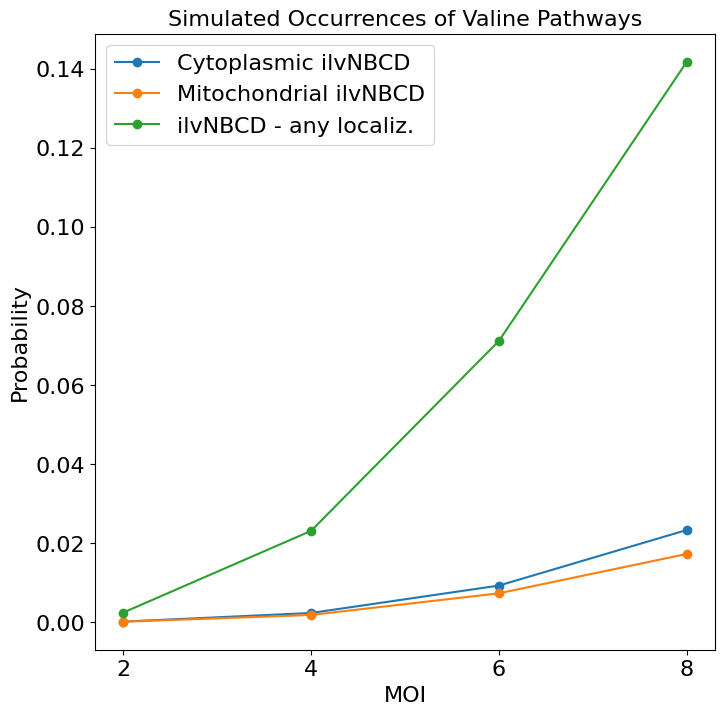

,Cytoplasmic ilvNBCD,Mitochondrial ilvNBCD,ilvNBCD - any localiz.
2,569,486,7407
4,7118,5612,69409
6,27924,22042,213515
8,70070,51907,425235


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define conditional gene set criteria
conditional_gene_sets = {
    "Cytoplasmic ilvNBCD": [
        {"PGK_ilvB", "Ef1a_ilvB"},
        {"PGK_ilvC", "Ef1a_ilvC"},
        {"PGK_ilvD", "Ef1a_ilvD"},
        {"PGK_ilvN", "Ef1a_ilvN"}
    ],
    "Mitochondrial ilvNBCD": [
        {"PGK-MTS_ilvB", "Ef1a-MTS_ilvB"},
        {"PGK-MTS_ilvC", "Ef1a-MTS_ilvC"},
        {"PGK-MTS_ilvD", "Ef1a-MTS_ilvD"},
        {"PGK-MTS_ilvN", "Ef1a-MTS_ilvN"}
    ],
    "ilvNBCD - any localiz.": [
        {"PGK_ilvB", "Ef1a_ilvB", "PGK-MTS_ilvB", "Ef1a-MTS_ilvB"},
        {"PGK_ilvC", "Ef1a_ilvC", "PGK-MTS_ilvC", "Ef1a-MTS_ilvC"},
        {"PGK_ilvD", "Ef1a_ilvD", "PGK-MTS_ilvD", "Ef1a-MTS_ilvD"},
        {"PGK_ilvN", "Ef1a_ilvN", "PGK-MTS_ilvN", "Ef1a-MTS_ilvN"}
    ],
}

# Folder where simulation CSVs are saved
csv_dir = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs"

# Function to count occurrences of conditional TU sets
def count_conditional_tu_set(df_combinations, conditions):
    def matches_all_conditions(row):
        row_set = set(row.split(", "))
        return all(any(g in row_set for g in cond) for cond in conditions)
    matching_combinations = df_combinations[df_combinations["TU_Combination"].apply(matches_all_conditions)]
    return matching_combinations["Frequency"].sum()

# Process each MOI dataset
moi_values = [2, 4, 6, 8]
results = {set_name: {} for set_name in conditional_gene_sets}

for moi in moi_values:
    file_path = os.path.join(csv_dir, f"tu_combinations_MOI{moi}_poisson_Jur.csv")
    try:
        df_combinations = pd.read_csv(file_path)
        for set_name, conditions in conditional_gene_sets.items():
            results[set_name][moi] = count_conditional_tu_set(df_combinations, conditions)
    except FileNotFoundError:
        for set_name in conditional_gene_sets:
            results[set_name][moi] = None

# Convert results to DataFrame and normalize
df_results = pd.DataFrame(results)
num_cells = 3000000
df_results_relative = df_results / num_cells

# Plot
plt.figure(figsize=(8, 8))
for set_name in df_results.columns:
    plt.plot(df_results.index, df_results_relative[set_name], marker='o', linestyle='-', label=set_name)

plt.xlabel("MOI", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.xticks(moi_values, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title("Simulated Occurrences of Valine Pathways", fontsize=16)

# Save
output_svg_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_sim_outputs/Sim_Jur_NBCD.svg"
plt.savefig(output_svg_path, format="svg")
plt.show()

# Display results
df_results

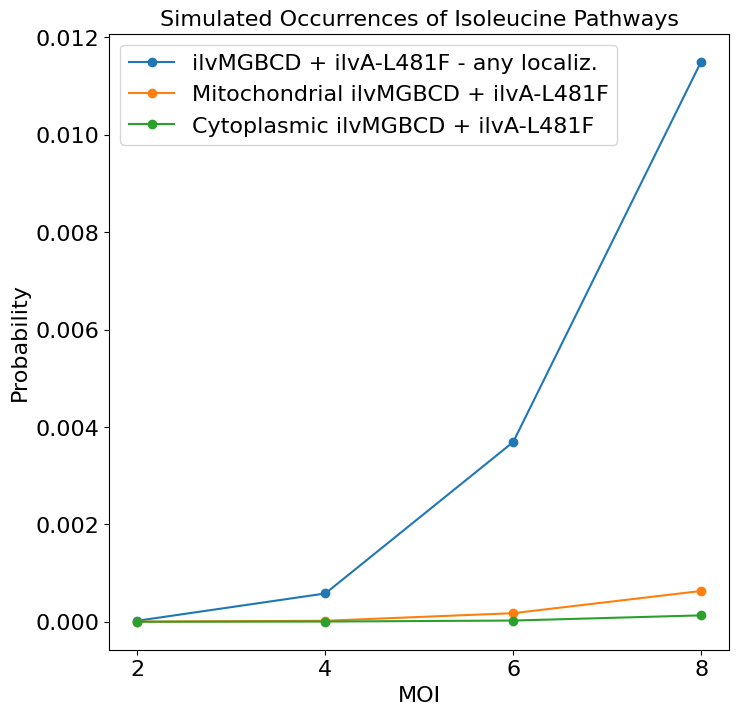

,ilvMGBCD + ilvA-L481F - any localiz.,Mitochondrial ilvMGBCD + ilvA-L481F,Cytoplasmic ilvMGBCD + ilvA-L481F
2,61,2,0
4,1741,59,11
6,11072,526,72
8,34502,1894,392


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define conditional gene set criteria
conditional_gene_sets = {
    "ilvMGBCD + ilvA-L481F - any localiz.": [
        {"PGK_ilvB", "Ef1a_ilvB", "PGK-MTS_ilvB", "Ef1a-MTS_ilvB"}, 
        {"PGK_ilvC", "Ef1a_ilvC", "PGK-MTS_ilvC", "Ef1a-MTS_ilvC"},  
        {"PGK_ilvD", "Ef1a_ilvD", "PGK-MTS_ilvD", "Ef1a-MTS_ilvD"},  
        {"PGK_ilvM", "Ef1a_ilvM", "PGK-MTS_ilvM", "Ef1a-MTS_ilvM"},
        {"PGK_ilvG", "Ef1a_ilvG", "PGK-MTS_ilvG", "Ef1a-MTS_ilvG"},
        {"PGK_ilvA mut 2", "Ef1a_ilvA mut 2", "PGK-MTS_ilvA mut 2", "Ef1a-MTS_ilvA mut 2"}
    ],
    "Mitochondrial ilvMGBCD + ilvA-L481F": [
        {"PGK-MTS_ilvB", "Ef1a-MTS_ilvB"},
        {"PGK-MTS_ilvC", "Ef1a-MTS_ilvC"},  
        {"PGK-MTS_ilvD", "Ef1a-MTS_ilvD"},  
        {"PGK-MTS_ilvM", "Ef1a-MTS_ilvM"},
        {"PGK-MTS_ilvG", "Ef1a-MTS_ilvG"},
        {"PGK-MTS_ilvA mut 2", "Ef1a-MTS_ilvA mut 2"}
    ],
    "Cytoplasmic ilvMGBCD + ilvA-L481F": [
        {"PGK_ilvB", "Ef1a_ilvB"},
        {"PGK_ilvC", "Ef1a_ilvC"},  
        {"PGK_ilvD", "Ef1a_ilvD"},  
        {"PGK_ilvM", "Ef1a_ilvM"},
        {"PGK_ilvG", "Ef1a_ilvG"},
        {"PGK_ilvA mut 2", "Ef1a_ilvA mut 2"}
    ]
}

# Folder where simulation CSVs are saved
csv_dir = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_poisson_outputs"

# Function to count occurrences of conditional TU sets
def count_conditional_tu_set(df_combinations, conditions):
    def matches_all_conditions(row):
        row_set = set(row.split(", "))
        return all(any(g in row_set for g in cond) for cond in conditions)
    matching_combinations = df_combinations[df_combinations["TU_Combination"].apply(matches_all_conditions)]
    return matching_combinations["Frequency"].sum()

# Process each MOI dataset
moi_values = [2, 4, 6, 8]
results = {set_name: {} for set_name in conditional_gene_sets}

for moi in moi_values:
    file_path = os.path.join(csv_dir, f"tu_combinations_MOI{moi}_poisson_Jur.csv")
    try:
        df_combinations = pd.read_csv(file_path)
        for set_name, conditions in conditional_gene_sets.items():
            results[set_name][moi] = count_conditional_tu_set(df_combinations, conditions)
    except FileNotFoundError:
        for set_name in conditional_gene_sets:
            results[set_name][moi] = None

# Convert results to DataFrame and normalize
df_results = pd.DataFrame(results)
num_cells = 3000000
df_results_relative = df_results / num_cells

# Plot
plt.figure(figsize=(8, 8))
for set_name in df_results.columns:
    plt.plot(df_results.index, df_results_relative[set_name], marker='o', linestyle='-', label=set_name)

plt.xlabel("MOI", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.xticks(moi_values, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title("Simulated Occurrences of Isoleucine Pathways", fontsize=16)

# Save
output_svg_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Monte_Carlo_Simulations/Jur_sim_outputs/Sim_Jur_MGBCDA-L481F.svg"
plt.savefig(output_svg_path, format="svg")
plt.show()

# Display results
df_results